# Criteo data

In [1]:
import pandas as pd
import numpy as np
import torch

In [2]:
NUM_DENSE = 13
NUM_SPARSE = 26

In [3]:
dense_features = [f"DENSE_{i}" for i in range(NUM_DENSE)]
sparse_features = [f"SPARSE_{i}" for i in range(NUM_SPARSE)]

In [4]:
columns = ["labels"] + dense_features + sparse_features

In [5]:
column_types = {col: 'float32' for col in ["labels"] + dense_features}
column_types.update({col: 'str' for col in sparse_features})

In [6]:
day_to_load = 0

In [7]:
file_path = f"/data/day_{day_to_load}.gz"

In [8]:
# Function to convert hexadecimal string to integer
def hex_to_int(hex_string):
    if hex_string == 'nan':
        return -1
    return int(hex_string, 16)

def clean_chunk(chunk):
    chunk[dense_features] = chunk[dense_features].fillna(0).astype(np.float32)
    for sparse_feature_name in sparse_features:
        chunk[sparse_feature_name] = chunk[sparse_feature_name].astype(str).apply(hex_to_int)
    chunk["labels"] = chunk["labels"].astype(np.float64)
    return chunk

In [9]:
chunk_size = 1000000  # Adjust this value based on your system's memory constraints
total_rows = 0
total_size = 0
for chunk in pd.read_csv(file_path, sep='\t', header=None, names=columns,compression='gzip', chunksize=chunk_size):
    total_rows += len(chunk)
    chunk = clean_chunk(chunk)
    total_size += chunk.memory_usage(deep=True).sum() / 10**9
    print("done with ", total_rows, total_size, "gb")
# Display the resulting DataFrame

done with  1000000 0.268000132 gb
done with  2000000 0.536000264 gb
done with  3000000 0.804000396 gb
done with  4000000 1.072000528 gb
done with  5000000 1.34000066 gb
done with  6000000 1.6080007920000001 gb
done with  7000000 1.8760009240000002 gb
done with  8000000 2.144001056 gb
done with  9000000 2.412001188 gb
done with  10000000 2.68000132 gb
done with  11000000 2.948001452 gb
done with  12000000 3.2160015840000002 gb
done with  13000000 3.4840017160000003 gb
done with  14000000 3.7520018480000004 gb
done with  15000000 4.02000198 gb
done with  16000000 4.288002112 gb
done with  17000000 4.556002244 gb
done with  18000000 4.824002376 gb
done with  19000000 5.092002508 gb
done with  20000000 5.36000264 gb
done with  21000000 5.628002772 gb
done with  22000000 5.896002904 gb
done with  23000000 6.164003036 gb
done with  24000000 6.4320031680000005 gb
done with  25000000 6.7000033000000006 gb
done with  26000000 6.968003432000001 gb
done with  27000000 7.236003564000001 gb
done wi

In [254]:
# all_data = pd.read_csv(file_path, sep='\t', header=None, names=columns, dtype=column_types, compression='gzip')

In [257]:
chunk_size = 1000  # Adjust this value based on your system's memory constraints
all_dfs = []
num_chunks = 100000
original_chunks = 100000

for chunk in pd.read_csv(file_path, sep='\t', header=None, names=columns,compression='gzip', chunksize=chunk_size):
    if num_chunks % 100 == 0:
        print(f"Done with {original_chunks - num_chunks}")
    chunk = clean_chunk(chunk)
    all_dfs.append(chunk)
    num_chunks -= 1
    if num_chunks == 0:
        break
result_df = pd.concat(all_dfs)
# Display the resulting DataFrame
print(len(result_df))

Done with 0
Done with 100
Done with 200
Done with 300
Done with 400
Done with 500
Done with 600
Done with 700
Done with 800
Done with 900
1000000


In [258]:
result_df.memory_usage(deep=True).sum() / 10**9

0.268000132

In [196]:
category_reverse_map = {feature_name: {
    value: idx for idx, value in enumerate(np.unique(result_df[feature_name].values))
} for feature_name in sparse_features}

In [197]:
def tokenize_sparse(df):
    for feature_name in sparse_features:
        df[feature_name] = df[feature_name].map(category_reverse_map[feature_name]).astype(np.int64)
    return df

In [198]:
result_df = tokenize_sparse(result_df)

In [199]:
result_df.memory_usage(deep=True).sum() / 10**9

0.000268132

# All Data and Dataset

In [200]:
dense_tensor_data = torch.from_numpy(result_df[dense_features].fillna(0).values)
dense_tensor_data.size()

torch.Size([1000, 13])

In [201]:
sparse_tensor_data = {fn: torch.from_numpy(result_df[fn].values) for fn in sparse_features}

In [251]:
labels_tensor_data = torch.from_numpy(result_df["labels"].values.astype(np.float64))
labels_tensor_data.dtype

torch.float64

In [203]:
from typing import NamedTuple, Mapping, Tuple
import torch

class ModelInput(NamedTuple):
    dense_features: torch.Tensor
    sparse_features: Mapping[str, torch.Tensor]

# Model Architecture

An implementation of a deep learning recommendation model (DLRM). The model input consists of dense and sparse features. The former is a vector of floating point values. The latter is a list of sparse indices into embedding tables, which consist of vectors of floating point values. The selected vectors are passed to mlp networks denoted by triangles, in some cases the vectors are interacted through operators (Ops).

In [204]:
# output:
#                     probability of a click
# model:                        |
#                              /\
#                             /__\
#                               |
#       _____________________> Op  <___________________
#     /                         |                      \
#    /\                        /\                      /\
#   /__\                      /__\           ...      /__\
#    |                          |                       |
#    |                         Op                      Op
#    |                    ____/__\_____           ____/__\____
#    |                   |_Emb_|____|__|    ...  |_Emb_|__|___|
# input:
# [ dense features ]     [sparse indices] , ..., [sparse indices]

In [205]:
import torch.nn as nn

# MLP

In [206]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Dense Arch

In [207]:
import torch.nn as nn

class DenseArch(nn.Module):
    def __init__(self, dense_feature_count: int, output_size: int) -> None:
        super(DenseArch, self).__init__()  # Call the superclass's __init__ method
        self.mlp = MLP(input_size=dense_feature_count, hidden_size=output_size * 2, output_size=output_size) # D X O

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        # Input : B X D # Output : B X O
        return self.mlp(inputs)

In [208]:
# Let's test it

In [209]:
dense_tensor = dense_tensor_data

In [210]:
output_size = 16

dense_arch = DenseArch(len(dense_features), 16)
dense_out = dense_arch(dense_tensor)

In [211]:
dense_out.size()

torch.Size([1000, 16])

In [212]:
dense_out

tensor([[   8.5922,  -14.8579,   18.2647,  ...,   24.3201,  -20.5709,
           22.7247],
        [  -3.6356,  -35.8657,   92.9472,  ...,  216.2522, -212.5529,
          203.8681],
        [  31.4824,  -73.9705,  103.4953,  ...,  210.4490, -208.6847,
          201.9895],
        ...,
        [   8.0807,  -62.7716,  127.1147,  ...,  290.5576, -287.5867,
          271.2074],
        [   9.9738,  -35.6487,   26.3150,  ...,   33.6008,  -20.4599,
           21.7429],
        [ 339.5808, -520.6729,  164.6143,  ...,  437.1664, -136.6833,
          180.5337]], grad_fn=<AddmmBackward0>)

# Sparse Arch

In [213]:
from typing import List, Dict

class SparseArch(nn.Module):
    def __init__(self, embedding_dimensions: Mapping[str, Tuple[int, int]], output_size: int) -> None:
        super(SparseArch, self).__init__()

        # Create Embedding layers for each sparse feature
        self.embeddings = nn.ModuleDict({
            feature_name: nn.Embedding(num_embeddings, embedding_dim)
            for feature_name, (num_embeddings, embedding_dim) in embedding_dimensions.items()
        })

        # Create MLP for each sparse feature
        self.mlps = nn.ModuleDict({
            feature_name: MLP(input_size=embedding_dim, hidden_size=output_size * 2, output_size=output_size)
            for feature_name, (num_embeddings, embedding_dim) in embedding_dimensions.items()
        })

    def forward(self, inputs: Dict[str, torch.Tensor]) -> List[torch.Tensor]:
        output_values = []
        for feature, input_values in inputs.items():
            embeddings = self.embeddings[feature](input_values)
            sparse_out = self.mlps[feature](embeddings)
            output_values.append(sparse_out)
        
        return output_values

In [214]:
embedding_size = 16

embedding_dimensions = {fn: (num_categories[fn] +  1, embedding_size) for fn in sparse_features}
print(embedding_dimensions)

{'SPARSE_0': (23798, 16), 'SPARSE_1': (5621, 16), 'SPARSE_2': (7326, 16), 'SPARSE_3': (2170, 16), 'SPARSE_4': (5049, 16), 'SPARSE_5': (4, 16), 'SPARSE_6': (4309, 16), 'SPARSE_7': (902, 16), 'SPARSE_8': (31, 16), 'SPARSE_9': (20225, 16), 'SPARSE_10': (8234, 16), 'SPARSE_11': (12092, 16), 'SPARSE_12': (10, 16), 'SPARSE_13': (1124, 16), 'SPARSE_14': (2892, 16), 'SPARSE_15': (44, 16), 'SPARSE_16': (5, 16), 'SPARSE_17': (368, 16), 'SPARSE_18': (15, 16), 'SPARSE_19': (24509, 16), 'SPARSE_20': (14514, 16), 'SPARSE_21': (22660, 16), 'SPARSE_22': (7644, 16), 'SPARSE_23': (5091, 16), 'SPARSE_24': (43, 16), 'SPARSE_25': (31, 16)}


In [215]:
output_size = 16

In [216]:
sparse_arch = SparseArch(embedding_dimensions=embedding_dimensions, output_size=output_size)

In [217]:
sparse_tensor_data["SPARSE_0"].size()

torch.Size([1000])

In [218]:
sparse_out = sparse_arch(sparse_tensor_data)
sparse_out

[tensor([[ 1.9138e-01, -2.7532e-01,  7.1895e-02,  ...,  1.6434e-04,
           2.5164e-01, -1.4910e-01],
         [ 2.7270e-02, -2.9258e-01, -1.1397e-01,  ...,  7.2577e-02,
           1.5238e-01,  7.1552e-03],
         [ 1.9138e-01, -2.7532e-01,  7.1895e-02,  ...,  1.6434e-04,
           2.5164e-01, -1.4910e-01],
         ...,
         [-3.8699e-01,  2.3720e-02,  3.8290e-01,  ...,  3.0096e-02,
          -1.3998e-01,  4.3667e-01],
         [-8.1143e-02, -2.2335e-01,  4.9483e-01,  ...,  1.8980e-01,
          -3.4822e-01,  6.3213e-01],
         [-3.1963e-01, -2.6947e-01,  4.3315e-02,  ..., -5.4014e-01,
          -5.3092e-01,  3.4540e-01]], grad_fn=<AddmmBackward0>),
 tensor([[-0.2276,  0.0825, -0.0411,  ..., -0.0017,  0.1068, -0.3513],
         [-0.2657,  0.0818, -0.1853,  ...,  0.0143,  0.3552,  0.1297],
         [ 0.0737,  0.0521, -0.2887,  ..., -0.1145,  0.1072, -0.1055],
         ...,
         [-0.4943,  1.3268, -0.0692,  ..., -0.0969,  0.6054, -0.0542],
         [-0.2118,  0.1376, -0

# Dense Sparse Interaction

In [219]:
class DenseSparseInteractionLayer(nn.Module):    
    def forward(self, dense_out: torch.Tensor, sparse_out: List[torch.Tensor]) -> float:
        concat = torch.cat([dense_out] + sparse_out, dim=-1).unsqueeze(2)
        out = torch.bmm(concat, torch.transpose(concat, 1, 2))
        flattened = torch.flatten(out, 1)
        return flattened

In [220]:
class PredictionLayer(nn.Module):
    def __init__(self,dense_out_size: int , sparse_out_sizes: List[int], hidden_size: int): 
        super(PredictionLayer, self).__init__()
        concat_size = sum(sparse_out_sizes) + dense_out_size
        self.mlp = MLP(input_size=concat_size * concat_size, hidden_size=hidden_size, output_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs: torch.Tensor) -> float:
        mlp_out = self.mlp(inputs)
        result = self.sigmoid(mlp_out)
        return result

In [221]:
dense_sparse_interaction_layer = DenseSparseInteractionLayer()
ds_out = dense_sparse_interaction_layer(dense_out, sparse_out)

In [222]:
ds_out.size()

torch.Size([1000, 186624])

In [223]:
prediction_layer = PredictionLayer(dense_out_size=output_size, sparse_out_sizes=[output_size]*len(sparse_features), hidden_size=16)

In [224]:
pred_out = prediction_layer(ds_out)
pred_out.size()

torch.Size([1000, 1])

# Model

In [225]:
from dataclasses import dataclass

# parameters
# dense_input_feature_size
# sparse_embedding_dimenstions
# dense_output_size
# sparse_output_size
# dense_hidden_size
# sparse_hidden_size
# prediction_hidden_size

@dataclass
class Parameters:
    dense_input_feature_size: int
    sparse_embedding_dimenstions: Mapping[str, Tuple[int, int]]
    dense_output_size: int
    sparse_output_size: int
    dense_hidden_size: int
    sparse_hidden_size: int
    prediction_hidden_size: int

class DLRM(nn.Module):
    def __init__(self, parameters: Parameters):
        super(DLRM, self).__init__()
        self.dense_layer = DenseArch(dense_feature_count=parameters.dense_input_feature_size, output_size=parameters.dense_output_size)
        self.sparse_layer = SparseArch(embedding_dimensions=parameters.sparse_embedding_dimenstions, output_size=parameters.sparse_output_size)
        self.interaction_layer = DenseSparseInteractionLayer()
        self.prediction_layer = PredictionLayer(
            dense_out_size=parameters.dense_output_size, 
            sparse_out_sizes=[parameters.sparse_output_size]*len(parameters.sparse_embedding_dimenstions), 
            hidden_size=parameters.prediction_hidden_size
        )

    def forward(self, dense_features, sparse_features) -> float:
        dense_out = self.dense_layer(dense_features)
        sparse_out = self.sparse_layer(sparse_features)
        ds_out = self.interaction_layer(dense_out, sparse_out)
        return self.prediction_layer(ds_out)

In [228]:
parameters = Parameters(
    dense_input_feature_size=len(dense_features),
    sparse_embedding_dimenstions=embedding_dimensions,
    dense_output_size=16,
    sparse_output_size=16,
    dense_hidden_size=32,
    sparse_hidden_size=32,
    prediction_hidden_size=32)

In [229]:
dlrm = DLRM(parameters=parameters)

In [231]:
prediction = dlrm(dense_tensor, sparse_tensor_data)

In [232]:
from torchviz import make_dot

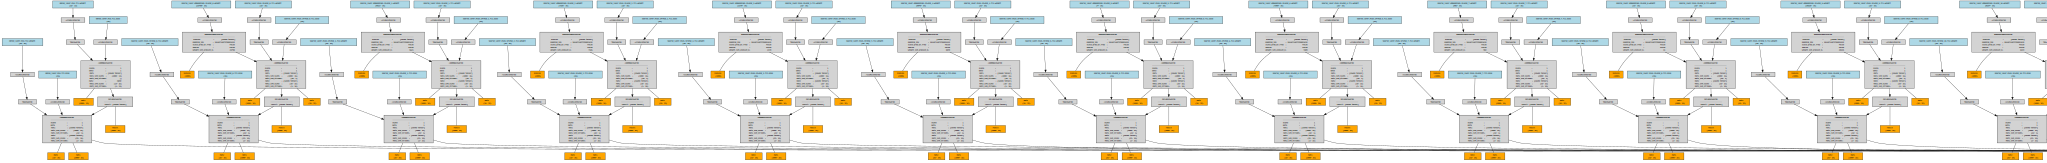

In [233]:
make_dot(prediction.mean(), params=dict(dlrm.named_parameters()), show_attrs=True, show_saved=True)

In [234]:
out = make_dot(prediction.mean(), params=dict(dlrm.named_parameters()), show_attrs=True, show_saved=True)

In [235]:
out.render("dlrm.pdf",format="pdf", view=False)

'dlrm.pdf.pdf'

In [237]:
model_input = ModelInput(dense_features=dense_tensor, sparse_features=sparse_tensor_data)

In [241]:
traced_model = torch.jit.trace(dlrm, [dense_tensor, sparse_tensor_data])

In [242]:
traced_model.graph

graph(%self.1 : __torch__.DLRM,
      %dense_features : Float(1000, 13, strides=[1, 1000], requires_grad=0, device=cpu),
      %sparse_features : Dict(str, Tensor)):
  %prediction_layer : __torch__.PredictionLayer = prim::GetAttr[name="prediction_layer"](%self.1)
  %interaction_layer : __torch__.DenseSparseInteractionLayer = prim::GetAttr[name="interaction_layer"](%self.1)
  %sparse_layer : __torch__.SparseArch = prim::GetAttr[name="sparse_layer"](%self.1)
  %dense_layer : __torch__.DenseArch = prim::GetAttr[name="dense_layer"](%self.1)
  %578 : str = prim::Constant[value="SPARSE_0"]()
  %input.5 : Long(1000, strides=[1], requires_grad=0, device=cpu) = aten::__getitem__(%sparse_features, %578) # /home/ksharma/anaconda3/envs/cuda-learn/lib/python3.11/site-packages/torch/jit/_trace.py:1074:0
  %580 : str = prim::Constant[value="SPARSE_1"]()
  %input.13 : Long(1000, strides=[1], requires_grad=0, device=cpu) = aten::__getitem__(%sparse_features, %580) # /home/ksharma/anaconda3/envs/cuda-le

In [243]:
print(traced_model.code)

def forward(self,
    dense_features: Tensor,
    sparse_features: Dict[str, Tensor]) -> Tensor:
  prediction_layer = self.prediction_layer
  interaction_layer = self.interaction_layer
  sparse_layer = self.sparse_layer
  dense_layer = self.dense_layer
  input = sparse_features["SPARSE_0"]
  input0 = sparse_features["SPARSE_1"]
  input1 = sparse_features["SPARSE_2"]
  input2 = sparse_features["SPARSE_3"]
  input3 = sparse_features["SPARSE_4"]
  input4 = sparse_features["SPARSE_5"]
  input5 = sparse_features["SPARSE_6"]
  input6 = sparse_features["SPARSE_7"]
  input7 = sparse_features["SPARSE_8"]
  input8 = sparse_features["SPARSE_9"]
  input9 = sparse_features["SPARSE_10"]
  input10 = sparse_features["SPARSE_11"]
  input11 = sparse_features["SPARSE_12"]
  input12 = sparse_features["SPARSE_13"]
  input13 = sparse_features["SPARSE_14"]
  input14 = sparse_features["SPARSE_15"]
  input15 = sparse_features["SPARSE_16"]
  input16 = sparse_features["SPARSE_17"]
  input17 = sparse_features["SP

In [244]:
compiled = torch.compile(dlrm, mode='max-autotune')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/home/ksharma/anaconda3/envs/cuda-learn/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
Process ForkProcess-11:
Process ForkProcess-10:
Process ForkProcess-5:
Process ForkProcess-2:
Process ForkProcess-12:
Process ForkProcess-7:
Process ForkProcess-8:
Process ForkProcess-9:
Process ForkProcess-4:
Process ForkProcess-6:
Process ForkProcess-1:
Process ForkProcess-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most 

In [246]:
torch._dynamo.reset()
explain_output = torch._dynamo.explain(compiled)(dense_tensor, sparse_tensor_data)
print(explain_output)

Graph Count: 1
Graph Break Count: 0
Op Count: 4
Break Reasons:
Ops per Graph:
  Ops 1:
    <built-in method cat of type object at 0x7b93896e48a0>
    <built-in method transpose of type object at 0x7b93896e48a0>
    <built-in method bmm of type object at 0x7b93896e48a0>
    <built-in method flatten of type object at 0x7b93896e48a0>
Out Guards:
  Guard 1:
    Name: "L['self'].sparse_layer.mlps['SPARSE_14'].relu"
    Source: local_nn_module
    Create Function: NN_MODULE
    Guard Types: None
    Code List: None
    Object Weakref: None
    Guarded Class Weakref: None
  Guard 2:
    Name: "L['self'].sparse_layer.embeddings['SPARSE_4']"
    Source: local_nn_module
    Create Function: NN_MODULE
    Guard Types: None
    Code List: None
    Object Weakref: None
    Guarded Class Weakref: None
  Guard 3:
    Name: "L['sparse_features']['SPARSE_14']"
    Source: local
    Create Function: TENSOR_MATCH
    Guard Types: ['TENSOR_MATCH']
    Code List: ["hasattr(L['sparse_features']['SPARSE_14']

# Dataset

# Train Loop